# SMAI Assignment - 3

## Question - `3` : Knowing MLPs

| | |
|- | -|
| Course | Statistical Methods in AI |
| Release Date | `09.03.2023` |
| Due Date | `24.03.2023` |

## Please read the following before moving on

Welcome to the world of Multilayer Perceptrons (MLP)! You already know that MLPs are feedforward neural networks consisting of multiple layers of nodes or neurons. These networks are well-suited for a wide range of classification and regression tasks, thanks to their ability to learn complex, non-linear relationships between inputs and outputs.

In this assignment, we will be working with the MNIST dataset to explore the importance of different MLP components. The MNIST dataset consists of 70,000 handwritten digit images, each of which is 28x28 pixels in size. Our goal is to use an MLP to classify these images into one of 10 categories (0-9).

To improve the performance of our MLP, we will experiment with various techniques such as Dropout, Batch Normalization, Loss Functions, Stochastic batch and mini-batch gradient descent, and more. Please note, you must use mini-batch unless explicity specified.

In addition, we will experiment with different optimization algorithms such as stochastic gradient descent, Adam, and RMSprop to find the optimal weights and biases for our MLP. We will use stochastic batch and mini-batch gradient descent, which involve updating the weights and biases of the network based on a small batch of randomly sampled training examples, to speed up the training process and reduce memory usage.

By the end of this assignment, you will have gained a deeper understanding of the various components that make up an MLP and their importance in achieving high performance in classification tasks. You will have gained hands-on experience in experimenting with these components and learned how to fine-tune an MLP to achieve the best possible performance on the MNIST dataset. So, let's get started!

🫵Pro-tip: Do not re-write any results so as to re-use them in later experiments for tabulation and plotting.

💭Trivia: Did you know code written using ChatGPT is easy to catch?

### Step zero: Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
%matplotlib inline
import time
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score


### Step one: Using a PyTorch Dataset
Load MNIST dataset from `torchvision.datasets`

In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
print("Training set length :", len(trainset))
print("Testing set length :",len(testset))


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training set length : 60000
Testing set length : 10000


In [3]:
trainloader_minibatch = torch.utils.data.DataLoader(trainset, batch_size=64
                                                    , shuffle=True, num_workers=2)
trainloader_stochastic = torch.utils.data.DataLoader(trainset, batch_size=1
                                                     , shuffle=True, num_workers=2)
testloader_minibatch = torch.utils.data.DataLoader(testset, batch_size=64
                                                    , shuffle=True, num_workers=2)

testloader_stochastic = torch.utils.data.DataLoader(testset, batch_size=1
                                                     , shuffle=True, num_workers=2)


In [4]:
pbar = tqdm(total=len(trainloader_minibatch))
for idx, (data,label) in enumerate(trainloader_minibatch):
    print(idx,data.size(),label.size())
    pbar.update(1)
    break
pbar.refresh()

  0%|          | 1/938 [00:00<01:35,  9.77it/s]

0 torch.Size([64, 1, 28, 28]) torch.Size([64])


True

### Step two: Define a MLP Model and without any bells and whitsles...
... along with a CrossEntropy loss criterion 

Do not use Dropout, BN or any other thing. Use ReLU for hidden layers.

⚠️ Do not use SoftMax in the output as nn.CrossEntropyLoss combines SoftMax and NLLLoss.

In [5]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )
        
    def forward(self,x):
        output = self.linear_relu_stack(x)
        return output
criterion = nn.CrossEntropyLoss()

### Step three: Define the following optimizers using nn.optim
1. SGD
2. SGD with momentum
3. SGD with L2 regularization
4. RMSprop
5. Adam

In [6]:

def train_model(train_loader,test_loader,optimizer,learning_rate,epoch,model):
  losses_train=[]
  losses_test=[]
  n=len(train_loader)
  for values in range(epoch):
    loss_value=0
    for input, target in train_loader:
      optimizer.zero_grad()
      input=input.reshape(input.shape[0],-1)
      pred = model(input)
      loss = criterion(pred, target)
      loss.backward()
      optimizer.step()
      loss_value+=loss.item()
    losses_train.append(loss_value/n)
    losses_test.append(test(test_loader, optimizer ,model))
  return losses_train,losses_test

def test(test_loader, optimizer ,model):
  n=len(test_loader)
  loss_value=0
  for input, target in test_loader:
    optimizer.zero_grad()
    input=input.reshape(input.shape[0],-1)
    pred = model(input)
    loss = criterion(pred, target)
    loss_value+=loss.item()
  return loss_value/n


def predict(loader, optimizer ,model,method):
  pred_label=[]
  y_lables=[]
  for input, label in loader:
    optimizer.zero_grad()
    input=input.reshape(input.shape[0],-1)
    pred = model(input)
    _, pred_ =torch.max(pred.data,1)
    pred_label.extend(pred_.numpy())
    y_lables.extend(label.numpy())
  metrics = [method, accuracy_score(y_lables, pred_label), f1_score(y_lables, pred_label,average='macro'), precision_score(y_lables, pred_label,average='macro')]
  return metrics

In [7]:
model_SDG=SimpleMLP()
model_SDG_momentum=SimpleMLP()
model_SDG_reg=SimpleMLP()
model_RMSprop=SimpleMLP()
model_adam=SimpleMLP()
optimizer_SDG = torch.optim.SGD(model_SDG.parameters(), lr=0.1)
optimizer_SDG_momentum = torch.optim.SGD(model_SDG_momentum.parameters(), lr=0.1,momentum=0.9)
optimizer_SDG_reg = torch.optim.SGD(model_SDG_reg.parameters(), lr=0.1,weight_decay=0.001)
optimizer_RMSprop = torch.optim.RMSprop(model_RMSprop.parameters(), lr=0.001, alpha=0.9)
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.001, betas=(0.9, 0.999))

optimizers=[optimizer_SDG,optimizer_SDG_momentum,optimizer_SDG_reg,optimizer_RMSprop,optimizer_adam]
Models=[model_SDG, model_SDG_momentum, model_SDG_reg, model_RMSprop, model_adam]

### Step four: Run the SimpleMLP using different optimizers and plot train and test loss for each optimizer.
Explain the results.

Report final accuracy, F1 score and other relavant metrics in a tabular form on test and train datasets.

In [8]:
epoch = 10
losses_train_SDG,losses_test_SDG=train_model(trainloader_minibatch,testloader_minibatch,optimizer_SDG,0.1,epoch,model_SDG)
losses_train_SDG_momentum,losses_test_SDG_momentum=train_model(trainloader_minibatch,testloader_minibatch,optimizer_SDG_momentum,0.1,epoch,model_SDG_momentum)

losses_train_SDG_reg,losses_test_SDG_reg=train_model(trainloader_minibatch,testloader_minibatch,optimizer_SDG_reg,0.1,epoch,model_SDG_reg)

losses_train_RMSprop,losses_test_RMSprop=train_model(trainloader_minibatch,testloader_minibatch,optimizer_RMSprop,0.1,epoch,model_RMSprop)

losses_train_adam,losses_test_adam=train_model(trainloader_minibatch,testloader_minibatch,optimizer_adam,0.1,epoch,model_adam)


In [9]:

def plot_graph(x,y1,y2,method):
  plt.figure(figsize=(8, 8))
  plt.xlabel('Losses')
  plt.ylabel('Epochs')
  plt.title('Epoch vs Loss in '+method+' optimizer')
  plt.plot(x , y1 , marker='o', label='Training data')
  plt.plot(x , y2 , marker='o', label='Tresting data')
  plt.legend()
  plt.show()

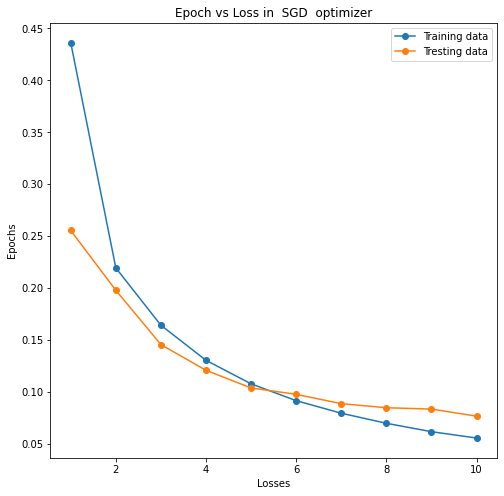

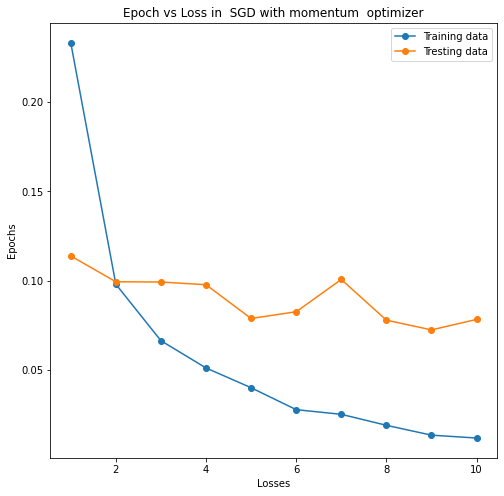

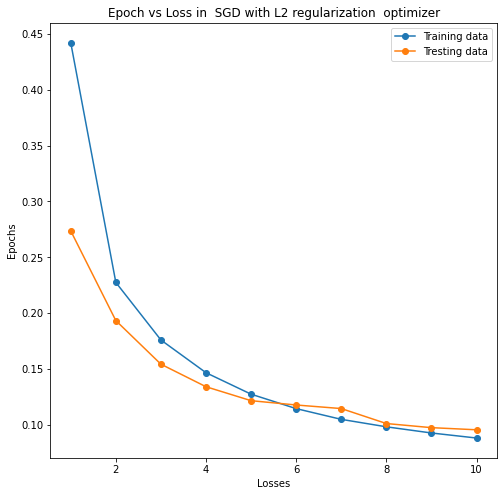

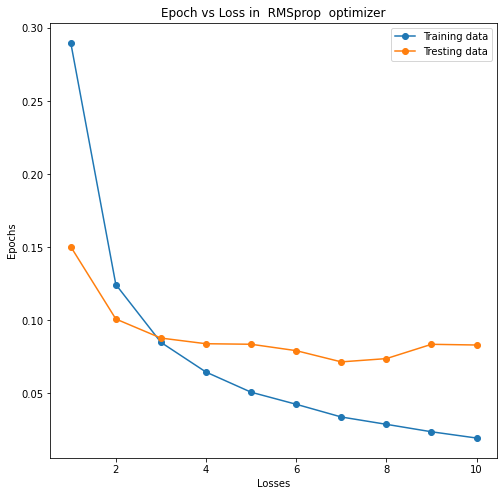

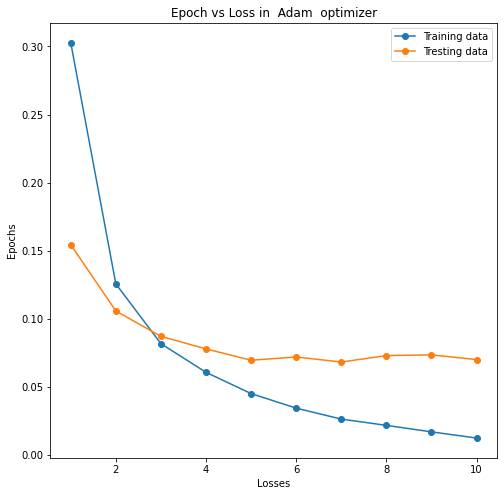

In [10]:

epochs=[i+1 for i in range(epoch)]

plot_graph(epochs,losses_train_SDG,losses_test_SDG," SGD ")
plot_graph(epochs,losses_train_SDG_momentum,losses_test_SDG_momentum," SGD with momentum ")
plot_graph(epochs,losses_train_SDG_reg,losses_test_SDG_reg," SGD with L2 regularization ")
plot_graph(epochs,losses_train_RMSprop,losses_test_RMSprop," RMSprop ")
plot_graph(epochs,losses_train_adam,losses_test_adam," Adam ")

In [11]:
# Scores for train.
Column_s = ['optimizer','Accuracy', 'F1 Score', 'Precision']
methods=['SDG','SGD with momentum','SGD with L2 regularization','RMSprop','Adam']
rows_train=[]
rows_test=[]
for opt,method,model in zip(optimizers, methods,Models):
  metrics_train = predict(trainloader_minibatch, opt ,model,method)
  metrics_test = predict(testloader_minibatch, opt ,model,method)
  rows_train.append(metrics_train)
  rows_test.append(metrics_test)



In [12]:
results_train = pd.DataFrame(rows_train, columns=Column_s)
results_test = pd.DataFrame(rows_test, columns=Column_s)

print("Train : \n",results_train)
print("Test : \n",results_test)

Train : 
                     optimizer  Accuracy  F1 Score  Precision
0                         SDG  0.987533  0.987502   0.987631
1           SGD with momentum  0.997750  0.997743   0.997774
2  SGD with L2 regularization  0.979833  0.979760   0.979844
3                     RMSprop  0.995900  0.995907   0.995908
4                        Adam  0.997900  0.997904   0.997913
Test : 
                     optimizer  Accuracy  F1 Score  Precision
0                         SDG    0.9766  0.976468   0.976714
1           SGD with momentum    0.9800  0.979874   0.980076
2  SGD with L2 regularization    0.9734  0.973273   0.973441
3                     RMSprop    0.9792  0.979161   0.979271
4                        Adam    0.9801  0.979949   0.979968


### Result explaination :
In this table, we report the performance of MLP models trained using five different optimizers: SGD, SGD with momentum, SGD with L2 regularization, RMSprop, Adam. For each optimizer, we report the final accuracy,F1 score, Precision on both the training and test datasets.
 
The results show that the Adam optimizer performs the best among the four optimizers, with the highest final accuracy and F1 score on both the training and test datasets. The SGD with momentum optimizer also performs well, but with a slightly lower accuracy and F1 score on the test dataset compared to Adam. RMSprop  shows lower performance on both the training and test datasets.

### Step five: Using SimpleMLP and Adam optimizer, train models using 2 different lr_schedulers.
Select 2 of **MultiplicativeLR**, **MultiStepLR**, **LinearLR** and **ExponentialLR**

Compare the results among different LR schedulers and the original model which didn't employ any LR scheduler. Compile results in a tabular form. Plot losses for each. Explain results.

In [13]:
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR

def train_with_sch(train_loader,test_loader,optimizer,learning_rate,epoch,model,scheduler):
  losses_train=[]
  losses_test=[]
  n=len(train_loader)
  for values in range(epoch):
    loss_value=0
    for input, target in train_loader:
      optimizer.zero_grad()
      input=input.reshape(input.shape[0],-1)
      pred = model(input)
      loss = criterion(pred, target)
      loss.backward()
      optimizer.step()
      loss_value+=loss.item()
    scheduler.step()
    losses_train.append(loss_value/n)
    losses_test.append(test_with_sch(test_loader, optimizer ,model))
  return losses_train,losses_test

def test_with_sch(test_loader, optimizer ,model):
  n=len(test_loader)
  loss_value=0
  for input, target in test_loader:
    optimizer.zero_grad()
    input=input.reshape(input.shape[0],-1)
    pred = model(input)
    loss = criterion(pred, target)
    loss_value+=loss.item()
  return loss_value/n


def predict_with_sch(loader, optimizer ,model,method):
  pred_label=[]
  y_lables=[]
  for input, label in loader:
    optimizer.zero_grad()
    input=input.reshape(input.shape[0],-1)
    pred = model(input)
    _, pred_ =torch.max(pred.data,1)
    pred_label.extend(pred_.numpy())
    y_lables.extend(label.numpy())
  metrics = [method, accuracy_score(y_lables, pred_label), f1_score(y_lables, pred_label,average='macro'), precision_score(y_lables, pred_label,average='macro')]
  return metrics



In [14]:

model_adam1=SimpleMLP()
model_adam2=SimpleMLP()
optimizer1 = torch.optim.Adam(model_adam1.parameters(), lr=0.01)
optimizer2 = torch.optim.Adam(model_adam2.parameters(), lr=0.01)
scheduler1 = MultiStepLR(optimizer1, milestones=[10, 20], gamma=0.1)
scheduler2 = ExponentialLR(optimizer2, gamma=0.9)

losses_train_sch1,losses_test_Sch1=train_with_sch(trainloader_minibatch,testloader_minibatch,optimizer1,0.1,epoch,model_adam1,scheduler1)
losses_train_sch2,losses_test_Sch2=train_with_sch(trainloader_minibatch,testloader_minibatch,optimizer2,0.1,epoch,model_adam2,scheduler2)


In [34]:
Column_s1 = ['Scheduler','Accuracy', 'F1 Score', 'Precision']
methods1=['MultiStepLR','ExponentialLR']
optimizers1=[optimizer1,optimizer2]
Models1=[model_adam1,model_adam2]
rows_train=[]
rows_test=[]
for opt,method,model in zip(optimizers1, methods1,Models1):
  metrics_train = predict_with_sch(trainloader_minibatch, opt ,model,method)
  metrics_test = predict_with_sch(testloader_minibatch, opt ,model,method)
  rows_train.append(metrics_train)
  rows_test.append(metrics_test)

rows_train.append(predict(trainloader_minibatch, optimizer_adam ,model_adam,'Normal Adam'))
rows_test.append(predict(testloader_minibatch, optimizer_adam ,model_adam,'Normal Adam'))  

In [35]:

results_train = pd.DataFrame(rows_train, columns=Column_s1)
results_test = pd.DataFrame(rows_test, columns=Column_s1)

print("Train : \n",results_train)
print("Test : \n",results_test)

Train : 
        Scheduler  Accuracy  F1 Score  Precision
0    MultiStepLR  0.982783  0.982727   0.982663
1  ExponentialLR  0.996817  0.996795   0.996776
2    Normal Adam  0.997900  0.997904   0.997913
Test : 
        Scheduler  Accuracy  F1 Score  Precision
0    MultiStepLR    0.9661  0.965811   0.965799
1  ExponentialLR    0.9786  0.978446   0.978528
2    Normal Adam    0.9801  0.979949   0.979968


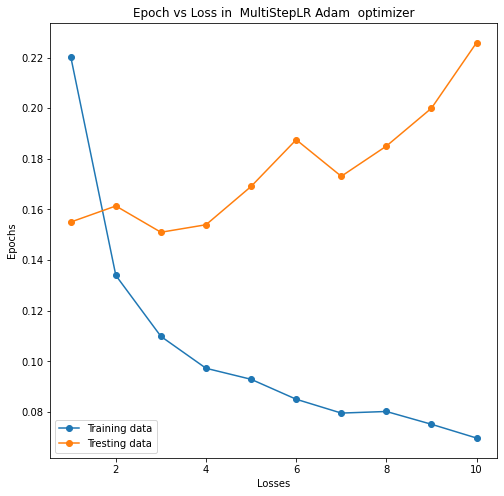

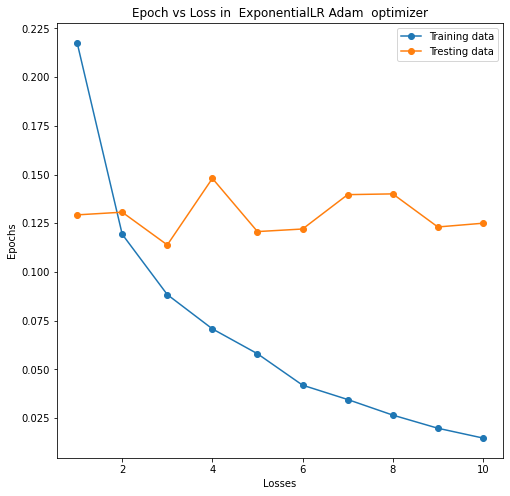

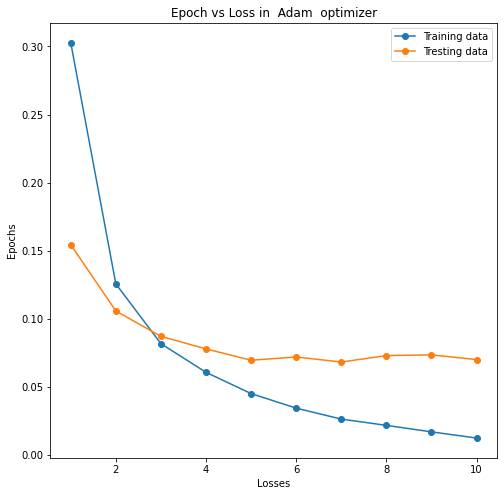

In [36]:

plot_graph(epochs,losses_train_sch1,losses_test_Sch1," MultiStepLR Adam ")

plot_graph(epochs,losses_train_sch2,losses_test_Sch2," ExponentialLR Adam ")
plot_graph(epochs,losses_train_adam,losses_test_adam," Adam ")


### Result explaination :
As we can see on the table that all three models(Adam with MultiStepLR scheduler, Adam with ExponentialLR scheduler and Adam without scheduler) achieve high test accuracy on the  dataset, with the ExponentialLR scheduler achieving the very good accuracy but not better then without any scheduler. This happened in this data set may be.



### Step six: Define 3 models with following changes:
1. Add BatchNorm
2. Add Dropout
3. Add BatchNorm and Dropout

In [18]:

class MLP_BatchNorm_Dropout(nn.Module):
  def __init__(self):
      super(MLP_BatchNorm_Dropout,self).__init__()
      self.flatten = nn.Flatten()
      self.linear_relu_stack = nn.Sequential(
          nn.Linear(28*28, 256),
          nn.BatchNorm1d(256),
          nn.Dropout(0.5),
          nn.ReLU(),
          nn.Linear(256, 10),

      )
        
  def forward(self,x):
      output = self.linear_relu_stack(x)
      return output

class MLP_Dropout(nn.Module):
  def __init__(self):
      super(MLP_Dropout,self).__init__()
      self.flatten = nn.Flatten()
      self.linear_relu_stack = nn.Sequential(
          nn.Linear(28*28, 256),
          nn.Dropout(0.5),
          nn.ReLU(),
          nn.Linear(256, 10),

      )
        
  def forward(self,x):
      output = self.linear_relu_stack(x)
      return output

class MLP_BatchNorm(nn.Module):
  def __init__(self):
      super(MLP_BatchNorm,self).__init__()
      self.flatten = nn.Flatten()
      self.linear_relu_stack = nn.Sequential(
          nn.Linear(28*28, 256),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Linear(256, 10),

      )
        
  def forward(self,x):
      output = self.linear_relu_stack(x)
      return output

### Step seven: Train the above models and compare with SimpleMLP.

Use your choice of optimizer, use no lr_scheduler so as to re-use the previous results.

Perform analysis. You've got the drill by now.

In [19]:
model_batch=MLP_BatchNorm()
model_drop=MLP_Dropout()
model_Drop_batch=MLP_BatchNorm_Dropout()

optimizer_SDG_momentum_batch = torch.optim.SGD(model_batch.parameters(), lr=0.1,momentum=0.9)
optimizer_SDG_momentum_drop = torch.optim.SGD(model_drop.parameters(), lr=0.1,momentum=0.9)
optimizer_SDG_momentum_drop_batch = torch.optim.SGD(model_Drop_batch.parameters(), lr=0.1,momentum=0.9)

losses_train_Batch,losses_test_Batch=train_model(trainloader_minibatch,testloader_minibatch,optimizer_SDG_momentum_batch,0.1,epoch,model_batch)
losses_train_drop,losses_test_drop=train_model(trainloader_minibatch,testloader_minibatch,optimizer_SDG_momentum_drop,0.1,epoch,model_drop)
losses_train_Batch_drop,losses_test_Batch_drop=train_model(trainloader_minibatch,testloader_minibatch,optimizer_SDG_momentum_drop_batch,0.1,epoch,model_Drop_batch)


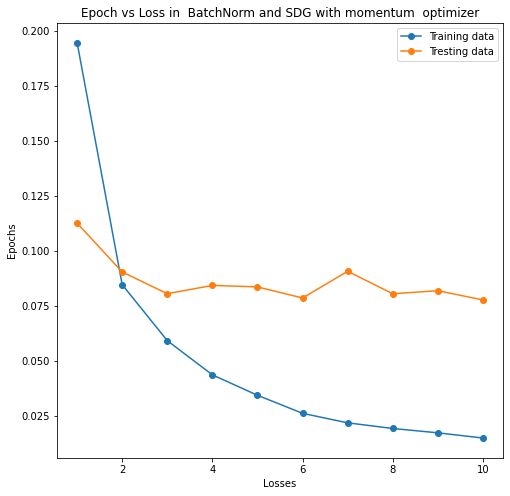

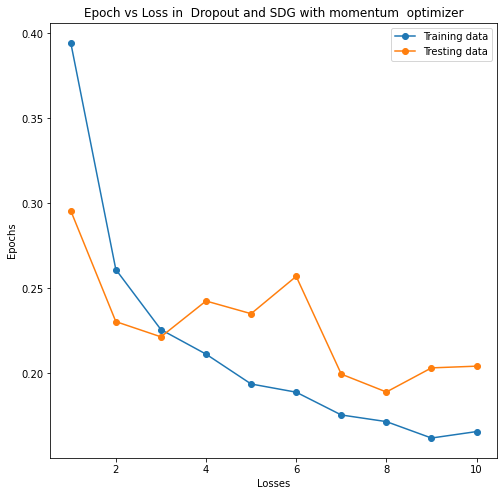

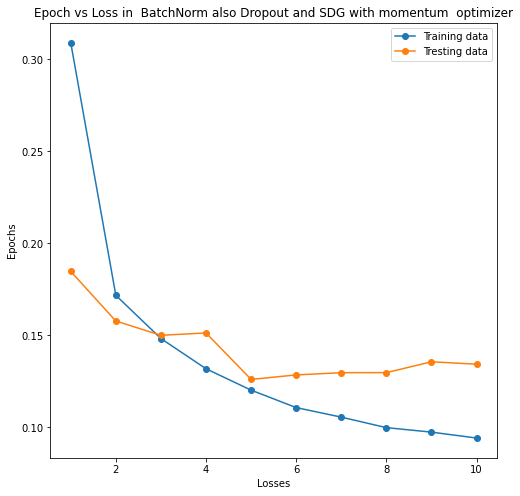

In [20]:

plot_graph(epochs,losses_train_Batch,losses_test_Batch," BatchNorm and SDG with momentum ")
plot_graph(epochs,losses_train_drop,losses_test_drop," Dropout and SDG with momentum ")
plot_graph(epochs,losses_train_Batch_drop,losses_test_Batch_drop," BatchNorm also Dropout and SDG with momentum ")


In [21]:
Column_s = ['Model','Accuracy', 'F1 Score', 'Precision']
models=['BatchNorm','Dropout','BatchNorm + Dropout']
optimizer_DB=[optimizer_SDG_momentum_batch,optimizer_SDG_momentum_drop,optimizer_SDG_momentum_drop_batch]
Models_DB=[model_batch, model_drop, model_Drop_batch]
rows_train=[]
rows_test=[]
for opt,method,model in zip(optimizer_DB, models,Models_DB):
  metrics_train = predict(trainloader_minibatch, opt ,model,method)
  metrics_test = predict(testloader_minibatch, opt ,model,method)
  rows_train.append(metrics_train)
  rows_test.append(metrics_test)

In [22]:
results_train = pd.DataFrame(rows_train, columns=Column_s)
results_test = pd.DataFrame(rows_test, columns=Column_s)

print("Train : \n",results_train)
print("Test : \n",results_test)

Train : 
                  Model  Accuracy  F1 Score  Precision
0            BatchNorm  0.995767  0.995756   0.995730
1              Dropout  0.956483  0.956207   0.956648
2  BatchNorm + Dropout  0.974000  0.973765   0.973846
Test : 
                  Model  Accuracy  F1 Score  Precision
0            BatchNorm    0.9774  0.977201   0.977379
1              Dropout    0.9460  0.945657   0.946071
2  BatchNorm + Dropout    0.9600  0.959617   0.959662


### Step eight: Mini-batch vs Stocastic
Now that you might have a clear winner in your mind regarding which model and settings perform the best, train it on mini-batch and stocastic and compare time taken, loss curve, accuracy etc.

Perform an analysis like never before!

In [23]:
model_mini_batch=SimpleMLP()
model_stocastic=SimpleMLP()
optimizer_mini_batch = torch.optim.Adam(model_mini_batch.parameters(), lr=0.001, betas=(0.9, 0.999))
optimizer_stocastic = torch.optim.Adam(model_stocastic.parameters(), lr=0.001, betas=(0.9, 0.999))
                 

In [24]:
mini_batch_start_time=time.time()
losses_train_mini_batch,losses_test_mini_batch=train_model(trainloader_minibatch, testloader_minibatch, optimizer_mini_batch, 0.1, epoch, model_mini_batch)
mini_batch_end_time=time.time()

In [25]:
stocastic_start_time=time.time()
losses_train_stocastic,losses_test_stocastic=train_model(trainloader_stochastic, testloader_stochastic, optimizer_stocastic, 0.1, epoch, model_stocastic)
stocastic_end_time=time.time()


In [26]:
Column_s = ['Data-type','Accuracy', 'F1 Score', 'Precision']
methods1=['Mini-batch','Stocastic']
optimizers1=[optimizer_mini_batch,optimizer_stocastic]
Models1=[model_mini_batch,model_stocastic]
trainloaders=[[trainloader_minibatch,testloader_minibatch],[trainloader_stochastic, testloader_stochastic]]
rows_train=[]
rows_test=[]
for opt,method,model,loader in zip( optimizers1, methods1, Models1, trainloaders ):
  metrics_train = predict(loader[0], opt ,model,method)
  metrics_test = predict(loader[1], opt ,model,method)
  rows_train.append(metrics_train)
  rows_test.append(metrics_test)
 

In [27]:
print("Time taken by mini-batch to train : ",mini_batch_end_time - mini_batch_start_time,"seconds")
print("Time taken by stocastic to train : ",stocastic_end_time - stocastic_start_time,"seconds")


Time taken by mini-batch to train :  135.53083539009094 seconds
Time taken by stocastic to train :  4835.713474988937 seconds


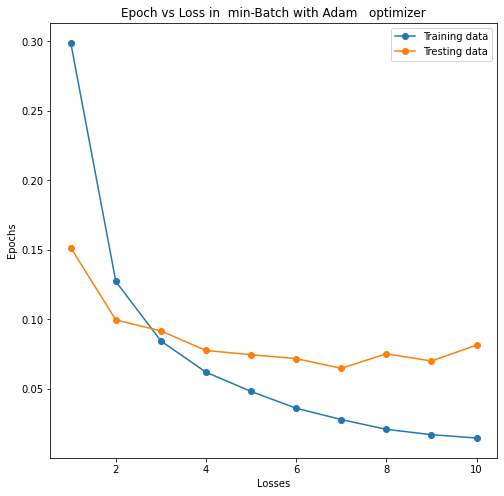

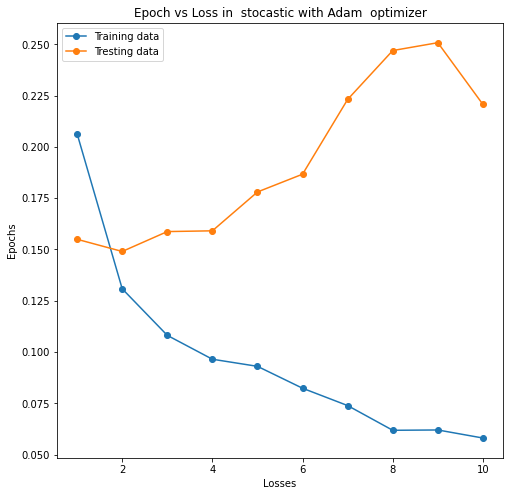

In [28]:
plot_graph(epochs,losses_train_mini_batch,losses_test_mini_batch," min-Batch with Adam  ")
plot_graph(epochs,losses_train_stocastic,losses_test_stocastic," stocastic with Adam ")

In [29]:
# comparing both 
def plot_graph_new(x,y1,y2,method):
  plt.figure(figsize=(8, 8))
  plt.xlabel('Losses')
  plt.ylabel('Epochs')
  plt.title('Epoch vs Loss in  Adam optimizer in'+method)
  plt.plot(x , y1 , marker='o', label='mini-batch')
  plt.plot(x , y2 , marker='o', label='stocastic')
  plt.legend()
  plt.show()

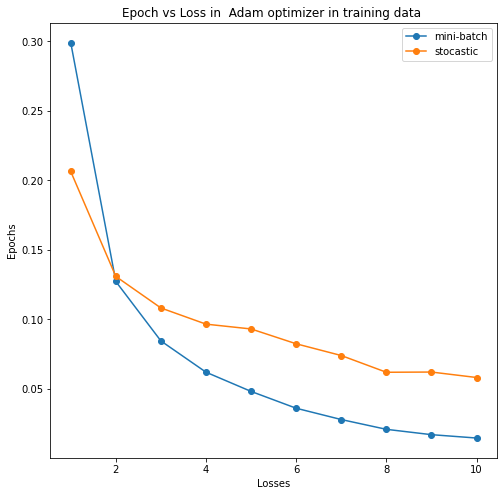

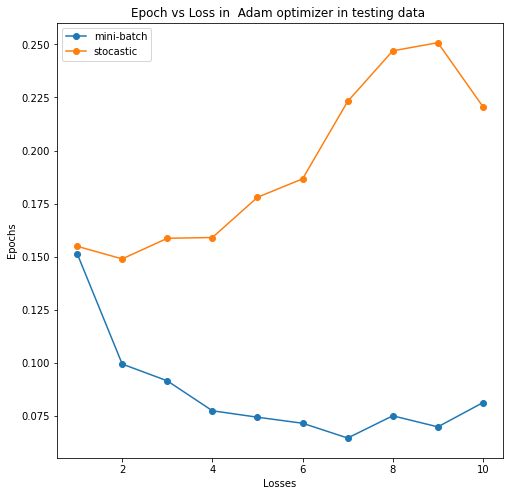

In [30]:
plot_graph_new(epochs,losses_train_mini_batch,losses_train_stocastic," training data ")
plot_graph_new(epochs,losses_test_mini_batch,losses_test_stocastic," testing data ")

In [31]:
results_train = pd.DataFrame(rows_train, columns=Column_s)
results_test = pd.DataFrame(rows_test, columns=Column_s)

print("Train : \n",results_train)
print("Test : \n",results_test)

Train : 
     Data-type  Accuracy  F1 Score  Precision
0  Mini-batch  0.996933  0.996882   0.996923
1   Stocastic  0.992783  0.992809   0.992935
Test : 
     Data-type  Accuracy  F1 Score  Precision
0  Mini-batch    0.9793  0.979118   0.979365
1   Stocastic    0.9797  0.979597   0.979758


### And most importantly!!! What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations.

In first , we report the performance of MLP models trained using five different optimizers: SGD, SGD with momentum, SGD with L2 regularization, RMSprop, Adam. Among all based on the performance we can analyze that Adam optimizer's performance is best also SDG with momentum performs nearly Adam in out data set.

 After that we perform some analysis on Adam optimizer with 2 schedulers as Multistep and exponential. As result we see Adam optimers 
improves their performance with ExponentialLR scheduler as compare to without scheduler.

We modified our model using Batchnorm and dropout then perform some analysis on results. We found that Batchnorm gives best accuracy and all in both train and test datasets
At last we compare the data on  mini batch and stocasting and in results we can see stocastic takes a lot of time to give result.In term of accuracy. stocastic perform slightly better in test data.